# DESI PV Y1 $z$-bin TFR Calibration

In redshift bins of width 0.001 (or 0.005), identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-bin joint fit to calibrate the TFR at $0.4R_{26}$, weighting the galaxies in the fit by $V(z=0.2)/V_{max}$.

Version: **3 August 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

/Users/kdouglass/miniforge3/envs/desi/lib/python3.10/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.365240555641251e-05,122.3223893029039,9.671537005812278,N
55,SGA-2020 55,PGC1203947

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [4]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [5]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

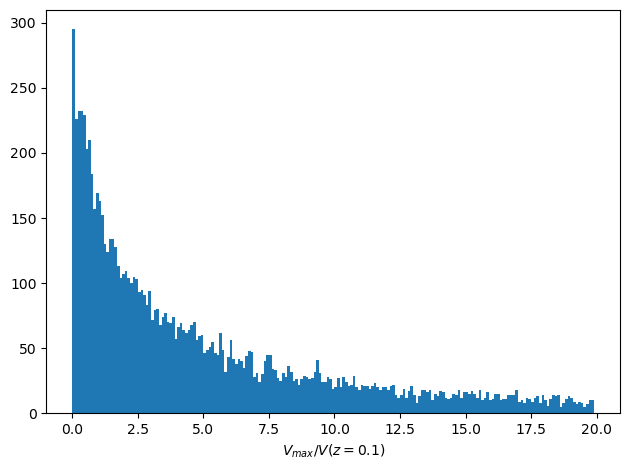

In [6]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

## Define dwarfs

Here, dwarfs are those with $R_{26} \leq 5$ kpc/h.

In [7]:
dwarf_boolean = 0.5*sgatab['D26_kpc'] <= 5

## Convert to CMB frame

In [8]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [9]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [10]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [11]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [12]:
lucey_VIpath = 'VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [13]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [14]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB,MORPHTYPE_AI,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,str10,str6
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.761488

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology
* Not a dwarf galaxy

The first 2.5 items have already been applied (our VI results have already been applied, but not John's).

In [15]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John & ~dwarf_boolean

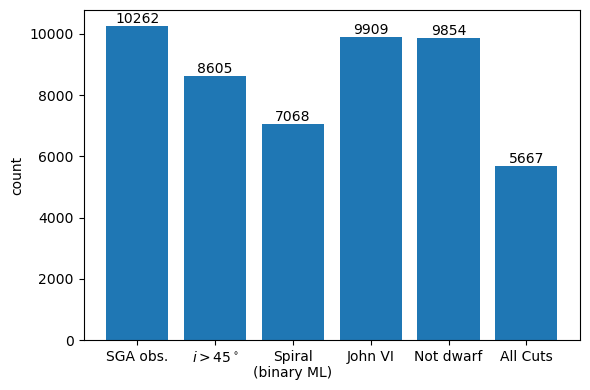

In [16]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    'Not dwarf' : np.sum(~dwarf_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(6,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [17]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [18]:
# Import E(B-V) dust map
# ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [19]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [20]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [21]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [22]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [23]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [24]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [25]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [26]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [27]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [28]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

## Load SN Ia Calibrators for the TFR Zero Point

Updated (July 2025) list of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [29]:
# zeroptpath = '/global/cfs/cdirs/desi/science/td/pv/combinedpv'
zeroptpath = '.'

In [30]:
zeroptab_all = Table.read(os.path.join(zeroptpath, 'PVsample_group_lookup+SNe.csv'))

# This is a list of all the TF + FP galaxies; only keep those with non-zero `MU_SN`
zeroptab_secondary = zeroptab_all[zeroptab_all['MU_SN'] > 0]
zeroptab_secondary[:5]

ID,group,zcmb,MU,MU_ERR,LOGDIST,LOGDIST_ERR,FP_FLAG,MU_FP,MU_FP_ERR,MU_TF,MU_TF_ERR,LOGDIST_FP,LOGDIST_FP_ERR,LOGDIST_TF,LOGDIST_TF_ERR,zcmb_gr,MU_SN,MU_SN_ERR,MU_DESI,MU_DESI_ERR,LOGDIST_SN,LOGDIST_SN_ERR,LOGDIST_DESI,LOGDIST_DESI_ERR
int64,str11,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633328785066757,2MRS711+,0.0039676663986918,32.00097867224519,0.6604661904704527,-0.3237695642772998,0.13209323809409051,True,31.73849041214853,0.48077000045780094,0.0,0.0,-0.24903482597904422,0.0961540000915601,0.0,0.0,0.0039533333333333,31.666571207539782,0.09129591053344505,31.738468671967322,0.48044940574448897,-0.28848911070838973,0.01825918210668901,-0.24902863619077392,0.09608988114889777
39633335592422861,2MRS711+,0.0044219686972581,31.443432913341425,0.7001885307384135,-0.16502708807805433,0.14003770614768266,True,31.73849041214853,0.48077000045780094,0.0,0.0,-0.24903482597904422,0.0961540000915601,0.0,0.0,0.0039533333333333,31.666571207539782,0.09129591053344505,31.738468671967322,0.48044940574448897,-0.28848911070838973,0.01825918210668901,-0.24902863619077392,0.09608988114889777
530182,2MRS99+,0.0047930320652416,32.47940875769096,0.7239065513601364,-0.3371487771800957,0.1447813102720272,False,30.929053813819788,0.31756824198384404,32.47940875769096,0.7239065513601364,0.03345970227711499,0.06351364839676879,-0.3371487771800957,0.1447813102720272,0.0058240909090909,32.4685,0.3462250857462526,31.17818507964822,0.29021798422398415,-0.23484747112467588,0.06924501714925052,-0.02609430598306092,0.05804359684479681
2842557700636673,2MRS99+,0.0061633210470812,30.47296800289217,0.7404426954770842,0.17379783886345607,0.14808853909541678,True,30.929053813819788,0.31756824198384404,32.47940875769096,0.7239065513601364,0.03345970227711499,0.06351364839676879,-0.3371487771800957,0.1447813102720272,0.0058240909090909,32.4685,0.3462250857462526,31.17818507964822,0.29021798422398415,-0.23484747112467588,0.06924501714925052,-0.02609430598306092,0.05804359684479681
2842569767649280,2MRS99+,0.0072261998346456,30.84064192659754,0.6981248856923716,0.1697020751725316,0.13962497713847433,True,30.929053813819788,0.31756824198384404,32.47940875769096,0.7239065513601364,0.03345970227711499,0.06351364839676879,-0.3371487771800957,0.1447813102720272,0.0058240909090909,32.4685,0.3462250857462526,31.17818507964822,0.29021798422398415,-0.23484747112467588,0.06924501714925052,-0.02609430598306092,0.05804359684479681


In [31]:
# zeroptab_primary = Table.read(os.path.join(zeroptpath, 'new_Pplus_group_match+SGA.csv'))
zeroptab_primary = Table.read(os.path.join(zeroptpath, 'new_Pplus_group_match+SGA_avg.csv'))
zeroptab_primary[:5]

CID,zCMB,zCMBERR,zHEL,zHELERR,MU_SH0ES,MU_SH0ES_ERR_DIAG,CEPH_DIST,IS_CALIBRATOR,USED_IN_SH0ES_HF,RA_SN,DEC_SN,ID_gr,ID_gal,ra_Lim,dec_Lim,source,sep_SN-Lim,SGA_ID,sep_Lim-SGA
str15,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,str9,str19,float64,float64,str9,float64,float64,float64
SN2016esh,0.04488,3e-05,0.04457,3e-05,36.1579,0.12988610395265537,-9.0,0,0,241.06,16.6902,SDSS228,SDSS581524,241.05988,16.69016,SDSS228+,0.4311776000325898,--,--
ASASSN-16fo,0.02994,0.00021,0.0289,0.00021,35.4803,0.12944141531982722,-9.0,0,0,203.149,-5.2725,2dF15428,2dF128339,203.14912,-5.27278,2dF15428,1.0929274169111631,64475.0,0.4609341882013722
ASASSN-16ct,0.04252,4e-05,0.04191,4e-05,36.2457,0.14873066260862283,-9.0,0,0,228.476,4.7573,SDSS1466,SDSS102315,228.47627,4.75715,SDSS1466,1.115336665428975,--,--
ASASSN-15so,0.00773,1e-05,0.00702,1e-05,32.7527,0.1274923134937946,32.8026,1,0,168.546,48.3187,2MRS4707,2MRS662,168.54575,48.31838,2MRS4707+,1.3004787534374072,995356.0,0.9298391203772391
ASASSN-15la,0.02845,1e-05,0.02782,1e-05,35.0558,0.15650734807030628,-9.0,0,1,213.213,35.7112,SDSS962,SDSS302584,213.21349,35.71089,2MRS834+,1.8232536690592336,737288.0,0.200539881958872


In [32]:
# Remove non-SGA galaxies
zeroptab_primary_SGA = zeroptab_primary[~zeroptab_primary['SGA_ID'].mask]

In [33]:
# Join the two 0pt catalogs together
zeroptab = join(zeroptab_secondary['ID', 'MU_SN', 'MU_SN_ERR', 'group'], 
                zeroptab_primary_SGA['SGA_ID', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG', 'CID'], 
                keys_left='ID', keys_right='SGA_ID', 
                join_type='outer')
zeroptab[:5]

ID,MU_SN,MU_SN_ERR,group,SGA_ID,MU_SH0ES,MU_SH0ES_ERR_DIAG,CID
int64,float64,float64,str11,float64,float64,float64,str15
--,--,--,--,10461.0,35.9905,0.2810696710781866,2007hu
--,--,--,--,20779.0,35.8698,0.13604785922608265,ASASSN-16db
--,--,--,--,22915.0,35.0136,0.17318562295987505,SNF20080514-002
--,--,--,--,37527.0,36.3303,0.09554459691683251,1995ac
40926,37.032,0.1278163917500412,2dF416+,--,--,--,--


In [34]:
# Merge together the ID and SGA_ID columns
zeroptab['SGA_ID'][zeroptab['SGA_ID'].mask] = zeroptab['ID'][zeroptab['SGA_ID'].mask]

# Remmove "old" ID column
zeroptab.remove_column('ID')

zeroptab[:5]

MU_SN,MU_SN_ERR,group,SGA_ID,MU_SH0ES,MU_SH0ES_ERR_DIAG,CID
float64,float64,str11,float64,float64,float64,str15
--,--,--,10461.0,35.9905,0.2810696710781866,2007hu
--,--,--,20779.0,35.8698,0.13604785922608265,ASASSN-16db
--,--,--,22915.0,35.0136,0.17318562295987505,SNF20080514-002
--,--,--,37527.0,36.3303,0.09554459691683251,1995ac
37.032,0.1278163917500412,2dF416+,40926.0,--,--,--


In [35]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
idx = np.isin(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])

#  Merge the tables so we can use the zero point later.
zeroptab = join(sgatab, zeroptab[idx], keys='SGA_ID')

#- Write catalog to file
# zeroptab.write('SGA_distances_0pt_iron_z0p1.fits', overwrite=True)
zeroptab['SGA_ID', 'GALAXY', 'MU_SN', 'MU_SH0ES', 'group', 'CID'].show_in_notebook()

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,SGA_ID,GALAXY,MU_SN,MU_SH0ES,group,CID
0,40926.0,PGC1068066,37.032,--,2dF416+,--
1,109750.0,PGC007299,36.481301221344594,36.481301221344594,2005hc+,2005hc+
2,124900.0,PGC1111212,36.8581,--,2dF2679+,--
3,185629.0,PGC1313612,35.825,--,SDSS32+,--
4,236390.0,PGC1093912,37.0786,--,2dF14+,--
5,364828.0,PGC1259192,35.6231,--,2MRS294+,--
6,431725.0,NGC1699,33.583117887482615,33.583117887482615,2MRS315+,2001ep+
7,506101.0,PGC1082809,37.0786,--,2dF14+,--
8,656304.0,PGC032277,36.1263,36.1263,2dF45+,PS16axi
9,719688.0,UGC08844,35.0276,--,6dF501+,--


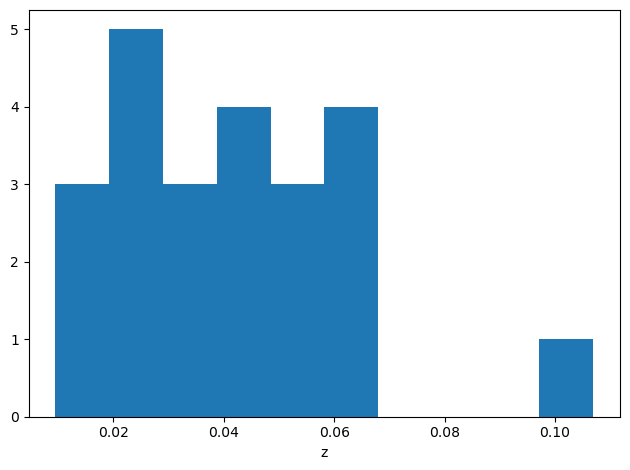

In [36]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])#, bins=np.arange(0, 0.12, 0.0025))

plt.xlabel('z');

In [36]:
# Only keep galaxies with a primary SN match
# zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [37]:
np.unique(zeroptab['CID'], return_counts=True)

(<MaskedColumn name='CID' dtype='str15' length=7>
 1999ac+
 2001ep+
 2005hc+
  500038
      --
 PS15cms
 PS16axi,
 array([ 1,  1,  1,  1, 17,  1,  1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

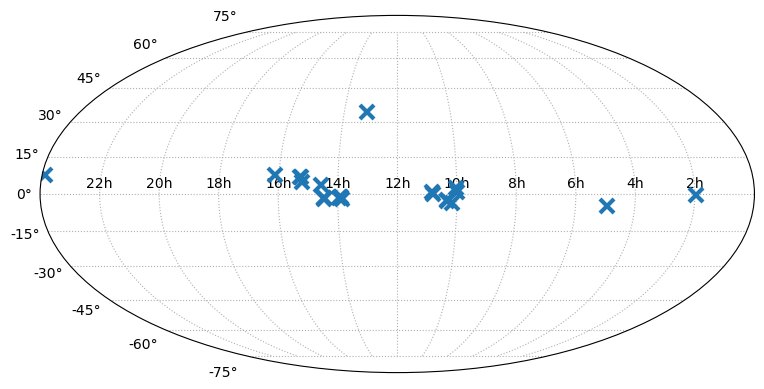

In [38]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_SNIa_calibrators.png', dpi=150);

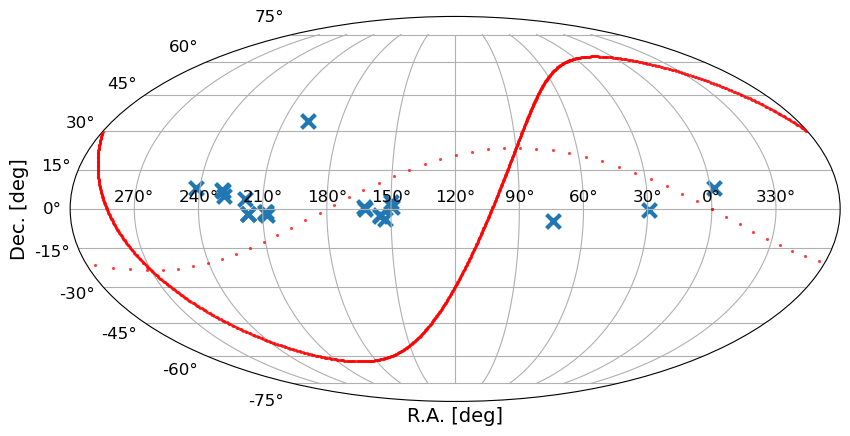

In [39]:
ax = init_sky()

ax.scatter(ax.projection_ra(sne_coords.ra.value), 
           ax.projection_dec(sne_coords.dec.value), 
           marker='x', 
           s=100,
           linewidth=3,
           color='tab:blue')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_0pt_sky_Anthony2.png', 
#             dpi=150, 
#             facecolor='none');

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [40]:
#- Clean up the distance modulus
use_primary = ~zeroptab['MU_SH0ES'].mask
mu = zeroptab['MU_SN']
mu[use_primary] = zeroptab['MU_SH0ES'][use_primary]
# mu = zeroptab['MU_PRIMARY']

mu_err = zeroptab['MU_SN_ERR']
mu_err[use_primary] = zeroptab['MU_SH0ES_ERR_DIAG'][use_primary]

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_ERR'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + mu_err**2)

In [41]:
# Save this table
zeroptab.write('SGA-2020_iron_Vrot_VI_0pt-Anthony2_calib_z0p1_R26dwarfs.fits', 
               overwrite=True)

In [42]:
zeroptab['SGA_ID', 'D26_kpc', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'V_0p4R26', 'V_0p4R26_ERR'].show_in_notebook()

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,SGA_ID,D26_kpc,R_MAG_SB26,R_MAG_SB26_ERR,V_0p4R26,V_0p4R26_ERR
,,kpc,,,,
0,40926.0,28.58454771708347,16.696472,0.0065811076,136.35142178525604,11.074703336870135
1,109750.0,42.34779922242629,15.013978,0.0113418605,221.3755771256751,8.774282536170919
2,124900.0,26.760046348583327,16.818043,0.032047212,143.17112816644325,34.61067012636111
3,185629.0,15.943648701231227,16.74443,0.023938801,118.22404252663176,10.30302451309546
4,236390.0,29.201396206101446,17.108109,0.030829139,132.93922299389146,9.693889582725964
5,364828.0,15.101189979483186,17.001926,0.019800633,98.2998665738336,10.911703633791037
6,431725.0,18.98358140666423,13.250422,0.004055838,159.04723205510138,11.274472967436228
7,506101.0,32.09442197347618,16.420128,0.02698361,148.86839576404628,7.266022158130458
8,656304.0,23.69295520949068,15.03111,0.0047636353,181.73653288642595,10.048159182113666


# Redshift bins

Separate the galaxies into redshift bins of width 0.005, starting at a redshift of 0.03.  (PVs are a significant fraction of the redshift at redshifts less than this.)

In [59]:
zmin = 0.03
zmax = 0.1
dz = 0.001
zbins = np.arange(zmin, zmax + dz, dz)

#- SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

zbin_indices = np.digitize(sgatab_sel['Z_DESI_CMB'], zbins, right=True)

In [60]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')

 0  z <= 0.030  627 galaxies
 1  0.030 < z <= 0.031   93 galaxies
 2  0.031 < z <= 0.032   81 galaxies
 3  0.032 < z <= 0.033   90 galaxies
 4  0.033 < z <= 0.034   76 galaxies
 5  0.034 < z <= 0.035   86 galaxies
 6  0.035 < z <= 0.036   55 galaxies
 7  0.036 < z <= 0.037   77 galaxies
 8  0.037 < z <= 0.038   72 galaxies
 9  0.038 < z <= 0.039   67 galaxies
10  0.039 < z <= 0.040   78 galaxies
11  0.040 < z <= 0.041   97 galaxies
12  0.041 < z <= 0.042   79 galaxies
13  0.042 < z <= 0.043   74 galaxies
14  0.043 < z <= 0.044   45 galaxies
15  0.044 < z <= 0.045   61 galaxies
16  0.045 < z <= 0.046   67 galaxies
17  0.046 < z <= 0.047   71 galaxies
18  0.047 < z <= 0.048   64 galaxies
19  0.048 < z <= 0.049   93 galaxies
20  0.049 < z <= 0.050   79 galaxies
21  0.050 < z <= 0.051   66 galaxies
22  0.051 < z <= 0.052   75 galaxies
23  0.052 < z <= 0.053   74 galaxies
24  0.053 < z <= 0.054   80 galaxies
25  0.054 < z <= 0.055   79 galaxies
26  0.055 < z <= 0.056   67 galaxies
27  0.056

In [61]:
_, counts = np.unique(zbin_indices, return_counts=True)

print(np.min(counts[1:-1]), np.max(counts[1:-1]))

22 97


# Build the Calibration Table of SGA Galaxies

In [62]:
sgatab_sel['Z_BIN_IDX'] = zbin_indices

no_use = (zbin_indices == 0) | (zbin_indices == len(zbins))
caltab = sgatab_sel[~no_use]

rejtab = sgatab_sel[no_use]

# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony2_dVsys.fits', overwrite=True)
caltab[['Z_BIN_IDX', 'Z_DESI_CMB', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_ERR']]

Z_BIN_IDX,Z_DESI_CMB,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_ERR
int64,float64,float64,float64,float64,float64,float64
52,0.08162327483927467,38.0,16.728901859968826,0.1097937894913965,122.3223893029039,9.671537005812278
62,0.09120074612338591,117.0,15.954404164953896,0.11303674793725518,180.6557315191658,12.555107762887319
18,0.04770393135250317,1158.0,14.818769372779832,0.10821215985133983,177.66056756020413,9.72984498796923
8,0.03730090242889217,1289.0,15.155128632881553,0.13607703864259116,69.54198306734067,26.742366851179067
26,0.05517343391109497,1358.0,14.473279316226737,0.06547763495568182,199.7389320074389,7.021351014635882
33,0.0621114746308149,1548.0,16.460548734077033,0.09659160140251052,169.13249529335522,9.834260346331956
26,0.05541189869150731,1663.0,16.26892285369704,0.1353047625643276,140.65283727627954,9.956496209244492
49,0.07868601783175921,1849.0,15.21134799027916,0.07192519421227364,224.4427647941615,10.276851054314735
19,0.048805933559745496,1996.0,16.692477275806624,0.08932478640546558,125.9470302632088,10.746649525209024


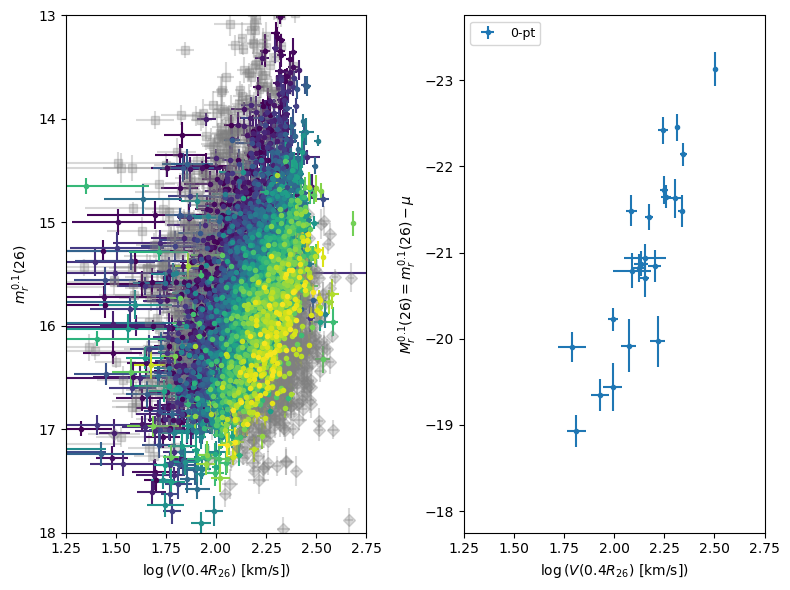

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

#-------------------------------------------------------------------------------
# Plot galaxies with failed cluster selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(rejtab['Z_BIN_IDX'])
markers = 'sDv^<>'
for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(rejtab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_zbin].data / rejtab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_zbin].data

    if _zbin_id == 0:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z $\leq$ {zbins[_zbin_id]:.3f} (rej.)')
    else:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z > {zbins[_zbin_id-1]:.3f} (rej.)')
#-------------------------------------------------------------------------------
# Plot galaxies and clusters passing all selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,len(_zbin_ids)+1)))

for _zbin_id in _zbin_ids:
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_ERR'][select_zbin].data / caltab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_zbin].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', 
                label=f'{zbins[_zbin_id-1]:.3f}-{zbins[_zbin_id]:.3f}')
#-------------------------------------------------------------------------------

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[18, 13],
       ylabel=r'$m_r^{0.1} (26)$')
# ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_ERR'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_ERR'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', color='tab:blue', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[-17.75, -23.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [65]:
#- Extract successful clusters
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_ERR'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_ERR'])
weights.append(np.array(1/zeroptab['MAX_VOL_FRAC']))

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['R_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

logV0 = 2.17207961088939


## Multiline Fit using HyperFit

In [66]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + clusters)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

             message: Optimization terminated successfully.
             success: True
                 fun: -217609.26131287456
                   x: [-6.444e+00 -2.111e+01 ...  1.688e+01  4.782e-01]
                 nit: 710
                nfev: 781135
          population: [[-6.450e+00 -2.111e+01 ...  1.687e+01  4.789e-01]
                       [-6.447e+00 -2.110e+01 ...  1.686e+01  4.789e-01]
                       ...
                       [-6.449e+00 -2.111e+01 ...  1.687e+01  4.785e-01]
                       [-6.447e+00 -2.110e+01 ...  1.686e+01  4.791e-01]]
 population_energies: [-2.176e+05 -2.176e+05 ... -2.176e+05 -2.176e+05]
                 jac: [-1.630e-01  1.164e-02 ... -5.821e-03  1.930e+00]
Ndim: 73 71


100%|███████████████████████████████████████| 1000/1000 [05:30<00:00,  3.03it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [102.46073523  99.04849908 102.60572543 103.39880611  98.24275355
  99.87371469  99.92294013 101.1612092   96.55454805  99.63814824
 102.10549336  99.59768751 100.52968725 101.49289683 100.92240749
  99.12474713 103.22639902  99.85654663  98.69902807 101.49513768
  99.17801623 100.42611546  99.79766782  99.7085448   99.30900016
 102.87695769  98.50819257 101.4427206  100.75175405 101.10083801
  98.02618766  99.76737805  98.90978004  98.32907348 102.13158505
  98.10381809 101.17080985  99.79976086 100.55466779 101.31648831
 100.18178855 100.74111749  99.31549858 101.91409722 102.02399439
 101.51258802 101.08841525 103.17344089 100.7273397  101.2481653
 100.66540285 100.57648617 101.29671284 100.40354851 103.75029566
 101.66991515  97.95091151 103.00664854 105.28607521 104.3760349
 102.94818169 101.42407362 107.56380341 104.59474707 102.55857534
 102.76418744 105.05530796 106.07589928 103.89081077 107.

100%|███████████████████████████████████████| 1000/1000 [05:30<00:00,  3.03it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [152.09731562 152.24948548 134.74121791 136.40724649 136.49540596
 139.97893616 146.27764361 142.78611484 145.8607403  142.62888352
 141.49422369 138.94823681 140.86947467 142.31855685 141.80825028
 150.21176855 141.6844518  149.66281968 141.85592885 147.2437611
 144.57748514 144.11646909 144.80582203 145.49764582 149.58815823
 147.17838121 148.13452858 146.93757912 143.53519373 149.4200074
 151.22829112 150.69907202 155.64495126 149.05141022 154.59662329
 151.08953565 144.30165513 147.43777303 152.50049168 153.07574746
 152.45724135 151.22704456 153.73020953 155.90450707 156.72523645
 151.17713082 150.36334926 157.09223709 149.92465135 153.09036512
 152.49315112 156.21953398 154.25558642 147.04095976 157.32262212
 152.77127103 156.3796902  157.73417187 156.37761126 156.4400867
 159.16899464 157.25777491 151.57591528 156.87242983 152.69660845
 160.27058987 161.52954581 156.14705459 153.46972224 153.5

100%|███████████████████████████████████████| 1000/1000 [05:29<00:00,  3.03it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [189.91940404 190.73145458 174.71942041 177.1091395  176.72268706
 177.5258811  184.86524807 184.29528091 185.53406995 182.4887322
 188.29769233 182.9862391  177.51090454 189.55714865 184.6893268
 185.07332389 188.7716436  194.28776217 181.8225771  179.66581286
 184.08195968 183.14241221 192.42645265 182.81263219 192.86221668
 191.76394163 182.81929902 184.81451111 184.83523888 194.52322199
 191.14181725 191.54116353 190.3985432  186.09941203 189.88227769
 190.15847029 183.52076475 186.12766949 186.39125715 182.07877622
 194.60415171 190.62446503 192.08386959 191.26235037 188.63240686
 186.57895981 186.77654906 189.58987564 182.70059307 189.71356872
 186.02651689 191.93390942 185.52349009 190.56226356 192.6582519
 188.5982569  191.69724712 189.84844191 190.36911519 192.32696572
 183.52069653 188.8869428  193.36607918 194.3308637  187.52646491
 190.09958968 190.53146068 191.9076422  184.92022799 191.9

100%|███████████████████████████████████████| 1000/1000 [14:25<00:00,  1.16it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [215.20596576 208.5950647  190.65844239 195.05501633 189.16662632
 197.8043345  200.118679   198.97894043 203.47932448 196.49080303
 199.0255324  198.52324671 188.15688978 201.5835967  203.77378777
 207.19161749 204.19221701 204.84784301 205.3565401  195.99383495
 204.45348507 203.79957394 208.94329754 204.10654312 205.5717809
 206.4361923  209.91154591 209.15252618 216.74019661 217.4860946
 205.98314757 208.37326503 217.43472456 217.68315971 212.28657857
 201.69940965 204.78664366 210.4254201  198.68535781 213.907513
 211.07197036 206.58998003 208.99052163 214.59886731 222.17444252
 207.94438327 213.97988589 214.58352693 208.55883888 213.13220696
 209.38944314 212.43761758 205.00484171 207.0875244  204.9523485
 211.29329585 204.68198179 221.15462014 202.56878445 222.03873391
 219.41363868 206.1435179  212.1782358  209.24381514 205.12417196
 216.57450064 212.76214835 206.07909727 211.18629186 196.422

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.05it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [228.8645004  251.5570882  232.05605282 228.68683314 231.53087352
 228.02471397 242.10582242 230.2563879  235.24063037 237.69352998
 241.34406974 241.52972373 234.49069219 236.55285022 244.22555675
 232.83955918 243.19738741 236.76381994 237.86728208 241.01770379
 241.9951102  242.96630409 247.39043196 233.85283532 240.07452825
 246.94300954 243.91879863 241.7065034  237.92156091 247.3251923
 231.19079338 250.87705213 251.64187397 245.84121507 236.94705268
 241.94567255 251.95663628 239.84265928 230.91326969 247.09046061
 243.40740597 248.09997081 241.10610138 244.22036132 245.25439212
 232.84638924 245.501663   228.07232324 241.72034589 246.69018892
 247.21308872 239.79029928 252.2577162  242.55401528 246.79078689
 243.59325323 247.77750007 238.01707088 237.69964561 244.74447331
 238.54098006 239.51699062 238.85845037 247.90550381 233.77850844
 241.15741958 238.17763017 236.36655471 233.57904279 237

100%|███████████████████████████████████████| 1000/1000 [05:29<00:00,  3.04it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [246.40219309 255.84945763 240.43269264 245.58531553 239.88555564
 247.23441855 242.40803792 247.57059802 257.59206136 247.33511178
 241.86364321 258.06951007 260.30259288 248.32099491 247.94855481
 245.59107845 255.96394639 246.16868807 251.08636053 253.26301995
 253.35143466 256.54418492 247.93116147 263.71470296 239.80184892
 259.13565083 246.97332717 266.65005998 242.64688636 247.03671745
 253.14233577 252.39075918 254.43565117 241.61930597 265.27836059
 260.9285874  255.33796909 246.71094106 247.9636737  263.72989413
 236.0601373  264.51896892 261.16428174 255.87013037 253.29588024
 254.51189248 252.77202854 242.81884651 246.15835252 251.66609354
 259.87590363 256.95308405 258.52262554 256.5867117  252.43137714
 249.44650132 258.97023082 250.55586238 245.07370992 265.91538753
 260.67534386 249.12834282 256.64704866 253.33985785 243.26704951
 251.57874394 255.04309238 258.60356133 255.84962016 26

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.05it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [270.41371875 278.0742272  264.72161959 265.70202878 272.05319358
 282.53627019 267.82812152 279.37384368 295.48710238 273.6132626
 267.3665327  276.69362476 280.67646467 282.29448506 277.00391514
 287.85107659 277.2626451  272.28132263 292.63366351 276.05537742
 284.70165685 283.79024524 279.36850476 282.14849728 270.33736399
 283.03062956 264.97037543 288.42788482 277.40135899 283.28807393
 288.28447247 277.87228294 286.40710055 280.12400288 292.10465429
 279.81317448 282.50833139 273.22914881 266.42325302 290.94792351
 278.75311059 294.38141137 283.60304535 280.14740312 286.91309962
 278.33675168 272.28156409 269.23948441 278.30824939 283.76526149
 292.32734645 281.87949601 283.9592157  283.52106462 280.53284274
 271.1726528  279.97922083 285.5976971  275.60902168 281.38923617
 287.41606883 276.81467279 274.32072389 272.54879162 260.4393074
 278.13447406 276.92288803 277.53055921 291.37427649 277.

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.04it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [292.05468026 289.38903952 272.19177309 279.78774819 272.78315437
 291.1161292  275.47378561 291.9983794  288.69346154 271.42896711
 277.08503326 284.89435935 282.26075731 291.89658831 274.70954052
 286.90866817 292.89867902 275.23613645 294.06634517 278.55615264
 300.39990656 276.6807667  291.20095177 288.79472466 289.11345354
 286.2371068  274.7121067  280.35763564 291.87067556 286.47781127
 293.70321685 299.65592508 295.4415343  297.37114508 303.21262411
 288.09805764 291.78245082 278.91693891 280.12535971 291.99898442
 294.52289291 295.16074417 295.31561607 301.51083042 293.58876412
 292.1952679  287.8097831  270.66428689 309.49357392 291.79725831
 299.79325954 284.31412781 288.72403308 286.34196835 281.26102255
 294.04414939 285.15962885 299.83952012 286.86386142 301.09573849
 300.31220641 278.74562104 284.0818529  290.79618586 279.93063393
 290.49153656 290.24599032 288.752235   297.77587082 28

100%|███████████████████████████████████████| 1000/1000 [05:29<00:00,  3.04it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [316.14675278 325.9610195  296.85071119 301.14307275 284.64317156
 307.05867418 304.83407929 314.15441188 295.91129903 282.84350105
 291.25581578 303.24649044 300.3319117  295.44831733 307.97331055
 300.89188951 313.59657278 314.70302655 320.51420243 297.64219106
 325.04433673 310.11576702 306.84382537 326.6516741  311.51457983
 304.02192817 308.22574854 313.12044123 311.98226912 309.5806569
 308.31245245 319.91323916 320.98451788 332.86203426 312.46064316
 319.92935987 305.38674572 309.93563557 301.66563933 318.35683344
 322.59502225 316.25587776 316.75579144 328.51357689 318.47210374
 310.32788309 307.19898776 295.62653427 335.28703261 312.98859665
 327.03758521 302.20912457 314.4950628  301.39852852 294.90588035
 302.42357214 303.65398648 316.07466407 299.93073634 323.39182941
 323.81544262 304.5257824  310.63915988 312.61712949 306.82342322
 303.27627081 315.43823159 295.47286961 318.87565954 297

100%|███████████████████████████████████████| 1000/1000 [37:26<00:00,  2.25s/it]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [309.59395969 325.64088308 297.69159486 303.37731154 284.99692965
 301.68809257 304.52574802 313.79067421 304.09669662 289.39273081
 298.69344668 314.01493201 308.12155487 304.5402485  308.71059911
 314.06096965 322.95589981 312.12453124 324.32656021 305.68376401
 327.8346056  320.91061336 311.87689913 324.82140782 302.6971949
 306.45827904 318.56745154 314.17868494 317.59121299 318.02823869
 316.37645199 318.29914141 330.27185833 328.56056614 314.56221251
 323.93104693 303.51018028 313.87957255 319.60499479 319.8717847
 317.4380954  331.45011008 315.13619232 331.9791469  327.94769837
 312.92174599 305.93217175 300.97632516 335.88386658 321.20808502
 325.0177578  308.55539808 314.34268086 316.10172194 308.63441929
 310.07880317 310.59331961 314.09289075 308.50199078 326.39266165
 340.45895779 303.25573618 303.89750105 318.60344336 306.53886651
 320.31252735 319.84102116 302.53824513 327.92264643 317

100%|███████████████████████████████████████| 1000/1000 [21:19<00:00,  1.28s/it]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [334.14899964 349.26844249 315.83513023 312.14327567 298.23916781
 314.07003959 318.08519525 334.52117011 322.45409207 325.29678895
 320.24745738 329.25586699 313.53152324 331.35402736 337.92535881
 337.64596033 326.7736379  328.19425807 339.42745181 338.00603218
 348.72448066 334.46316972 324.14432382 340.02613992 327.57000513
 321.56341277 337.15304716 332.41449052 344.05400044 333.36632845
 340.66900552 341.91129058 345.59435495 338.35883876 327.3178506
 343.44918957 321.44360855 327.50166586 335.39877142 331.92776336
 338.76717686 343.91857063 330.72243165 352.10602591 343.11684055
 345.47718652 339.19238793 328.45905474 335.95962625 332.06585042
 342.13915243 325.86376343 339.52664364 334.708247   356.74039819
 345.45137448 335.29276651 352.52004508 327.04979026 341.24120346
 350.03343356 327.15089153 332.27424432 333.54441706 320.82006188
 332.45329645 333.66765488 334.87429536 356.12540572 32

100%|███████████████████████████████████████| 1000/1000 [21:24<00:00,  1.28s/it]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [334.7829099  339.40871607 314.51188014 308.09110771 316.12351587
 316.28968468 317.38645864 326.64059621 322.94165717 325.44880418
 335.52872793 324.86591928 318.94784725 336.51246122 335.57695987
 348.1027613  323.52192945 331.7734202  353.18555121 332.65783961
 352.83770345 322.50153432 324.69330878 335.35149803 335.90256176
 331.86734038 341.79607984 335.12214413 342.8262504  335.54881148
 334.02290623 338.49825749 343.67480531 341.38973498 326.95476128
 339.67311911 335.04215603 333.98541481 337.25297371 334.81938003
 351.03626931 344.25829537 339.86314071 354.91192509 334.8703948
 351.87181664 334.59308622 335.7721327  338.49860198 335.62463729
 334.61868664 333.9022266  351.70957051 335.89742216 369.21192527
 352.03366442 351.24657099 362.51726827 326.59707894 351.56259176
 352.75472485 342.10955266 342.88971968 348.65803374 326.40008221
 333.87977635 340.13195166 344.5379379  352.4617945  32

100%|███████████████████████████████████████| 1000/1000 [14:07<00:00,  1.18it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [355.91975459 354.35705043 327.13102998 333.73057549 338.28712964
 332.17124346 326.5695472  352.10349977 345.50756367 337.52108985
 352.56066047 338.08689656 338.07372198 351.7554401  355.14534551
 370.71971395 336.70334667 360.77954098 350.32553811 347.54300155
 366.71255624 340.65448727 334.38527097 349.51488513 354.4181567
 345.88872452 353.30968656 357.6144773  361.80801652 351.02815668
 350.59626658 353.86867829 354.89364131 370.89772184 329.69581397
 362.77062544 349.62736682 351.14911964 363.37442873 357.90532236
 377.05841436 368.02751658 362.50743129 379.29962839 351.38194513
 374.67136631 357.69577755 358.70754526 351.54126544 374.20887701
 349.52416292 348.28181625 373.50766495 360.24270382 379.13041185
 367.00634623 371.36896555 387.94243754 350.65768205 364.81029322
 359.50079916 360.68920271 363.79255509 358.57112596 341.54994363
 345.53328648 351.59785344 344.14320261 366.3625694  34

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.05it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [364.95183932 351.94363044 327.53502499 338.96854695 329.06907628
 334.28025306 340.40586513 348.80544029 353.78295843 344.71652862
 363.19456263 345.15081794 329.28621331 347.95372479 352.11133344
 384.49187971 349.87552796 358.90729933 351.52790753 351.0616974
 365.51081863 345.8677637  337.51068859 350.91295532 362.93698121
 353.08693203 359.85658786 364.12501278 356.98121276 345.34425112
 353.01503233 368.98666484 371.16986857 370.06114602 331.71926644
 370.72158623 357.37937949 350.8996714  363.74011044 353.64830726
 378.64471943 367.20281338 381.30671182 382.72007472 342.7709114
 377.14617052 356.63963698 366.96102038 336.51512399 373.42362302
 344.18677965 358.52856288 367.85610359 359.78537569 377.64650836
 361.698385   379.29045002 386.36085111 356.35819115 371.78756364
 365.86511279 361.97144897 362.74177477 357.18669812 352.76483637
 341.39952617 359.31897683 362.52546123 373.84393069 345

100%|███████████████████████████████████████| 1000/1000 [45:31<00:00,  2.73s/it]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [384.04159139 365.83056996 340.76454996 350.23735138 349.94734281
 358.56693646 347.92186054 359.90812757 382.24817995 372.04211317
 388.7563914  357.31251991 343.17610678 349.37523857 361.05168481
 397.74146832 358.12024771 377.57787682 368.4402837  366.05758687
 383.75537809 364.58311525 345.5522623  380.98203285 374.00984258
 363.30900696 379.95211017 375.53804942 365.56878626 350.70862215
 367.72714382 393.13906084 390.52540117 399.74699652 351.51300956
 387.14253675 382.58559889 374.49528935 373.70142244 367.4223777
 385.32364631 388.16334145 399.64472581 402.01971455 371.01292554
 396.43374131 366.29092599 382.07847872 361.41184581 376.97344618
 355.33691749 379.39094271 389.78793632 386.96958777 371.48726536
 378.38060096 382.65151956 399.13760078 372.19512526 382.81266013
 373.92780138 380.36517329 377.93008796 382.4707287  365.12807161
 364.3367632  371.37498048 374.61669037 380.70869965 36

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.05it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [387.18992126 377.78639891 349.57276481 345.83999631 352.53840566
 362.86402122 350.93013803 356.18309052 394.14584248 370.18323795
 376.87026712 352.4687794  337.19980393 350.33839476 351.46877383
 398.70269749 356.35629372 377.15940216 361.29412057 358.56087856
 396.77740293 375.91092207 353.49831723 371.16562132 380.8496348
 373.35910756 387.43838033 366.65595877 373.54227994 350.80245815
 370.08301854 381.76992182 382.15919797 384.71108678 344.09724783
 391.55454873 381.52398071 383.12398471 371.90261423 362.83361226
 381.71646202 392.55706768 400.14920081 409.894473   387.09401479
 395.36576319 359.93922367 393.70305212 360.42759414 383.89101592
 365.07334235 389.0731194  388.90577807 391.5726002  369.74684335
 378.12892684 377.35128985 400.38778816 376.54542019 375.35284392
 389.37833676 380.09550389 380.71861179 381.37588494 368.47247989
 361.33893579 368.53276603 382.73708352 371.31001392 37

100%|███████████████████████████████████████| 1000/1000 [05:27<00:00,  3.05it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [382.38893203 400.0585624  363.53465228 352.99701285 364.72926853
 369.19683842 356.43836215 372.17810223 405.1549679  383.77922205
 398.85874615 358.19672092 356.79613742 369.31840626 352.71899515
 414.01911551 386.16042902 386.11534345 373.18844164 385.39522104
 419.79863977 402.86087026 385.51233042 373.21783123 409.35384346
 394.1290585  405.75871661 381.75105576 387.70812996 378.11062528
 386.92061654 384.71006582 403.3585365  388.64812285 368.09372572
 405.71330713 391.86351383 390.31273503 388.81898709 383.35818648
 401.54942111 409.6823566  424.09323822 426.50522772 393.74350157
 402.13850904 378.46598297 409.54819591 372.68035505 404.95099349
 392.38383455 411.11914181 400.76730516 409.3440461  378.36560055
 397.31489743 383.21953813 414.28961757 404.62995271 386.17565492
 409.16012565 392.58196296 385.94975049 393.74010001 385.30160767
 378.76099095 379.50613904 394.36912382 384.39646011 3

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.04it/s]


Niterations/Max Iterations:  18000 / 100000
Integrated ACT/Min Convergence Iterations:  [377.02654726 410.16090327 361.50238799 348.37562814 366.04861282
 362.95899124 363.78810049 375.18657973 396.75243554 383.66338978
 402.96906677 369.15228814 369.74522444 376.59266472 347.33864413
 411.12737533 393.70135383 389.00937878 380.52421789 392.53326092
 417.99982887 402.78755381 392.7849769  373.96268521 402.76317203
 392.99570919 408.24849225 384.72804323 387.15120031 377.96112421
 387.00330516 375.14997377 400.33720807 378.20552349 371.76346837
 407.1811528  384.95578061 389.75088003 390.24682586 390.63621332
 407.43213741 414.91227302 428.98261952 432.42412652 394.7994861
 398.26854422 385.9073946  404.9633623  374.52156651 400.04933716
 396.77238291 412.72245058 401.40674034 407.19305086 388.94655785
 390.42989375 387.46204224 421.04318711 395.79197715 393.08041445
 413.55639131 401.97269164 377.97432821 392.30539158 382.84313345
 387.93548915 385.339748   396.6890041  384.73488645 38

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.04it/s]


Niterations/Max Iterations:  19000 / 100000
Integrated ACT/Min Convergence Iterations:  [389.98475628 433.94633893 364.23156307 352.88303228 373.14186651
 360.2666167  370.24666805 389.23314107 408.02678733 393.85132339
 426.94502561 390.30590123 381.93861144 384.97714216 366.78244319
 425.34132299 408.47079176 423.35881592 399.84999368 415.19036688
 416.20921488 410.64939272 401.57262495 388.73098264 415.53682286
 401.72325816 428.17470547 405.7225853  401.78017737 399.14888813
 407.20622635 392.12707013 416.82580903 395.55414226 396.37905902
 412.76959722 402.9936986  394.83395493 402.93073752 413.75418557
 433.01316749 419.62279982 446.94798086 451.33993996 413.61520203
 409.03950178 398.66741884 416.96512471 392.09836023 416.6792327
 417.54192697 429.76400755 418.41774635 403.7628569  400.65885426
 400.13036334 393.41205228 423.74317015 401.79725306 424.5530773
 413.38670327 418.93140822 395.72708571 410.97884762 396.29586315
 400.16295951 405.38169474 413.57740546 398.34984904 395

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.04it/s]


Niterations/Max Iterations:  20000 / 100000
Integrated ACT/Min Convergence Iterations:  [386.29141637 424.84569199 356.37544846 355.78684768 371.38444693
 355.32310978 356.10386488 393.55452021 409.88506688 392.49991496
 423.93182906 392.50371885 386.88554757 390.31694288 365.7110325
 429.91605663 412.13207769 425.20680029 407.97173554 407.83130614
 406.2645364  411.29365401 403.39240444 389.26175442 407.5795629
 402.04151681 430.73239021 407.32457966 407.32586015 396.15751493
 409.16502759 395.33510329 433.45115387 384.63701498 392.86348447
 415.72414092 411.15184849 401.07387109 397.42388773 405.33372623
 427.54632869 414.03909965 445.83365338 452.43254788 413.84211509
 410.70427523 399.37742964 428.59541713 399.17887811 398.57527666
 426.91403754 426.57493714 421.75818635 407.33546988 409.22759548
 410.70831947 392.89364543 419.37167824 407.56630931 421.85167289
 413.50301138 414.9241469  393.24489073 411.16784297 397.18294187
 401.83855784 404.86838671 421.11492234 399.44995678 401

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.05it/s]


Niterations/Max Iterations:  21000 / 100000
Integrated ACT/Min Convergence Iterations:  [402.65711295 430.34980171 363.10756458 364.35348605 377.30108986
 368.34004755 364.76225214 407.38073417 430.30525342 404.76351103
 430.14327905 416.55296466 407.77620133 409.55921402 381.40625904
 437.27851864 424.8377689  448.52859143 432.70236847 422.98261946
 418.9336875  421.36328166 414.02740938 402.40663604 434.70349203
 418.98725456 442.31563412 422.30556783 418.57992896 421.7532968
 416.15935747 415.31946818 448.08511884 397.52383295 419.91772625
 426.25273048 418.52307489 415.9753202  418.21530586 424.8912861
 443.87103796 418.3370864  455.27706214 461.39673091 435.48666068
 420.14590167 408.52193705 442.55264771 419.59971241 412.7584958
 443.6196836  443.59787181 431.0897519  420.83858508 417.76090792
 427.52428171 401.93603185 431.57151862 418.34404306 425.91465074
 432.37127593 430.36581409 409.47917512 436.1732194  416.56238983
 410.33069057 428.28698094 429.68174962 413.03585934 426.

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.05it/s]


Niterations/Max Iterations:  22000 / 100000
Integrated ACT/Min Convergence Iterations:  [407.00861663 432.55625512 366.98595322 366.52814779 377.62817019
 367.1958332  363.49185293 408.03062934 430.13826626 407.64013022
 436.46482809 416.32854932 410.89404552 398.100347   379.14054941
 438.625748   423.49968423 436.99893234 428.45749922 424.13693938
 416.78084671 424.95138022 412.47045827 391.77079759 426.41717591
 424.68722706 430.64447831 428.88829129 416.10508386 424.17762975
 411.79489907 416.77131481 449.08267598 396.16742672 420.45893829
 427.95030428 417.14133336 413.56457693 414.93916047 423.98758635
 451.98923535 420.4378882  444.60198257 461.2689991  431.11650676
 412.03802134 406.78055405 445.13965374 427.67279566 413.12432142
 440.37017978 433.87812933 432.57379657 418.38520309 411.40075128
 426.44513106 400.71167008 425.98651959 410.16904173 432.42855877
 411.59207822 426.2379446  407.85930851 436.42432762 407.4395614
 399.70260217 435.38680434 419.04242443 411.50197727 41

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.05it/s]


Niterations/Max Iterations:  23000 / 100000
Integrated ACT/Min Convergence Iterations:  [416.3972336  433.07978938 378.61992583 372.74204367 391.21137452
 370.22131455 373.98036159 426.74236382 450.26731507 413.97684748
 455.63875879 435.76068631 423.92151078 406.38243514 405.14724863
 457.48455391 431.38148807 447.35214825 440.66558051 426.76679587
 425.09912206 436.39076054 419.75245699 400.77001992 432.26533049
 427.73437843 434.69976209 448.1816609  426.71510707 434.44532717
 426.5485081  433.58389616 464.57083775 408.92927353 425.17088655
 432.68823724 427.00869097 424.36957999 425.39268176 441.33436834
 462.99743948 431.41123163 462.8283371  477.43492786 443.98652334
 426.51793442 418.12045316 454.48940084 440.63604662 427.76706738
 444.78152549 448.97956856 438.00025724 431.1938433  416.14265546
 438.9583997  419.39611406 431.79944838 424.92992975 439.20720696
 431.12371021 432.85106767 421.93369842 443.20166476 429.94185561
 413.12471059 458.21109494 431.87532157 413.42109006 4

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.05it/s]


Niterations/Max Iterations:  24000 / 100000
Integrated ACT/Min Convergence Iterations:  [423.37775468 441.51891836 376.55709338 371.54624876 387.98194891
 380.79892485 384.98587481 421.42989295 448.58744793 414.25590264
 447.77618585 435.6077405  428.7578275  421.2859444  398.43073193
 452.19762272 424.78967551 437.52028107 436.20368046 423.89377919
 421.29998096 425.47240133 426.21254981 397.59485837 429.92226612
 429.79587425 434.31104185 436.95966678 429.00093299 430.97975817
 435.61464678 432.34491334 465.55991212 414.99890247 424.81339437
 441.31427633 430.60472333 425.07671747 416.58299325 446.11457577
 450.37413596 428.61964555 449.36701788 467.24347848 447.76192154
 419.68737319 423.10685528 450.1006286  440.44034246 418.74782456
 437.38710374 443.54280371 433.28952718 427.12714398 415.90694511
 444.02664174 426.99770571 435.49090329 430.5195741  432.97087894
 424.63146302 436.84149803 423.85155962 450.31656872 430.59469737
 409.27337454 461.79044418 433.1369729  419.56689322 4

100%|███████████████████████████████████████| 1000/1000 [05:28<00:00,  3.05it/s]


Niterations/Max Iterations:  25000 / 100000
Integrated ACT/Min Convergence Iterations:  [431.82469521 449.09009889 394.13541603 384.5631837  396.59782337
 392.49930499 407.91800275 430.57889847 451.33899902 440.35372599
 457.97203678 448.17387762 445.99180881 435.697442   407.1507165
 459.0410859  428.5267698  441.21324743 445.64724298 430.44090844
 439.89426485 436.47508495 442.1282176  401.2351629  444.56323625
 441.12945293 448.73902966 441.76969794 425.73954542 426.03017778
 443.38860145 446.71930778 473.803695   428.78561959 443.87272337
 442.97596798 452.00859643 438.97789019 428.14709095 462.30471198
 454.25774345 441.94186996 461.74991319 480.90765125 458.26050936
 431.43443426 433.55271082 453.91769484 455.72204696 433.75102759
 444.18082653 448.96206313 446.15410208 440.07919858 423.31194134
 449.24892873 438.77086984 442.31958654 438.18238196 448.81970137
 437.26378741 445.22257795 445.74609651 462.19228409 434.01701505
 427.22226901 461.35309406 443.47201058 428.26219729 44

100%|███████████████████████████████████████| 1000/1000 [47:45<00:00,  2.87s/it]


Niterations/Max Iterations:  26000 / 100000
Integrated ACT/Min Convergence Iterations:  [437.17025965 450.76656923 390.15329946 386.73065312 389.98534399
 402.82309007 396.93453059 431.21707815 446.587142   426.69572157
 454.12630627 449.5904548  435.573101   441.47811884 397.8378425
 461.86251125 438.46340614 429.72506816 433.71738994 427.82263334
 435.1865593  436.15482176 432.33353697 397.75772642 434.68686248
 428.27742475 447.79254435 429.14425409 425.5156288  432.18165852
 429.94032969 447.40656887 473.9921114  421.52612081 438.94628145
 438.07008389 445.49198497 442.1843415  437.38480213 458.27076
 455.38882994 441.84020598 457.81609774 475.5907627  463.04698909
 430.55335495 431.3199235  457.03643168 459.27745448 427.99981423
 440.16185816 441.55459696 434.95910882 444.48726783 422.67037997
 444.5793357  440.79211996 437.96337756 437.65446574 442.59987565
 433.3537217  441.88625939 444.09532527 458.25879546 435.73416613
 429.15100824 460.7739643  450.81952117 431.43628517 438.9

In [67]:
temp_outfile = open('cov_ab_iron_jointTFR_varyV0-R26dwarfs_z0p1_zbins0p001_Anthony2_weightsVmax-1_dVsys_KAD-20250804.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

In [68]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

KeyboardInterrupt: 

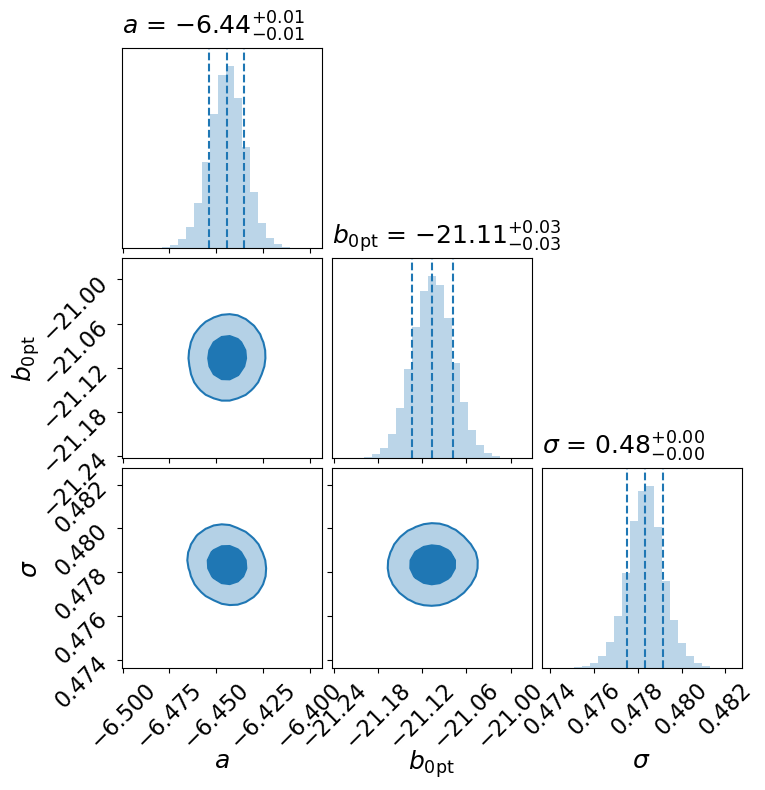

In [69]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$']
labels += [r'$\sigma$']

fig = corner(tfr_mcmc_samples[[0,1,-1],:].T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [70]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

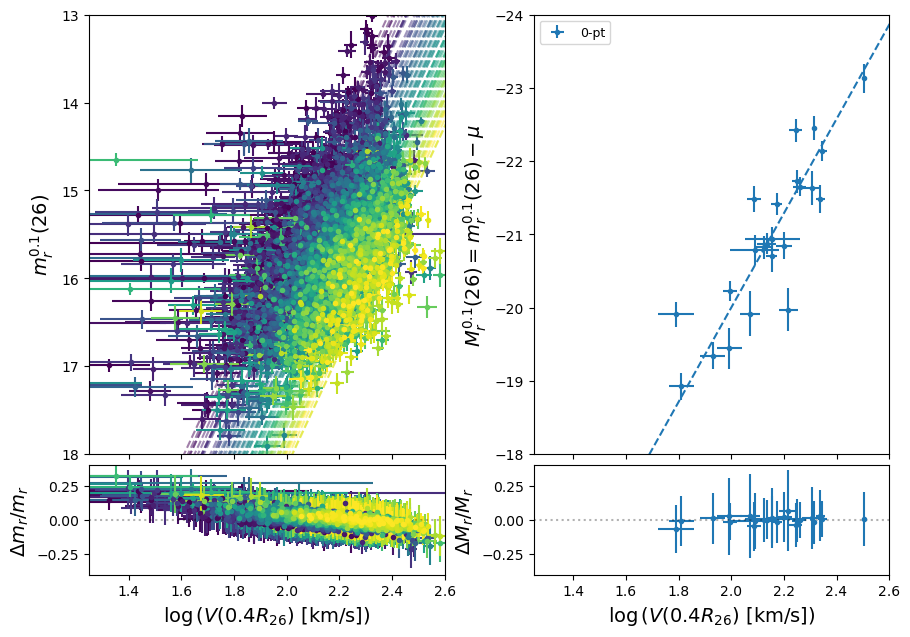

In [72]:
fig, axes = plt.subplots(2,2, figsize=(10,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot redshift bins
ax = axes[0,0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], 
                     xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.25, 2.6],
       ylim=[18, 13])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='.', color='tab:blue', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1.25, 2.6],
       ylim=[-18, -24]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='upper left', fontsize=9, ncol=2)

#- Plot residuals: clusters
ax = axes[1,0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                xerr=logV_err[0], yerr=mag_err[0],
                fmt='.', color='tab:blue')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[1.25, 2.6],
       ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

In [73]:
print(f'slope (alpha): {-a_/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.58 +/- 0.004


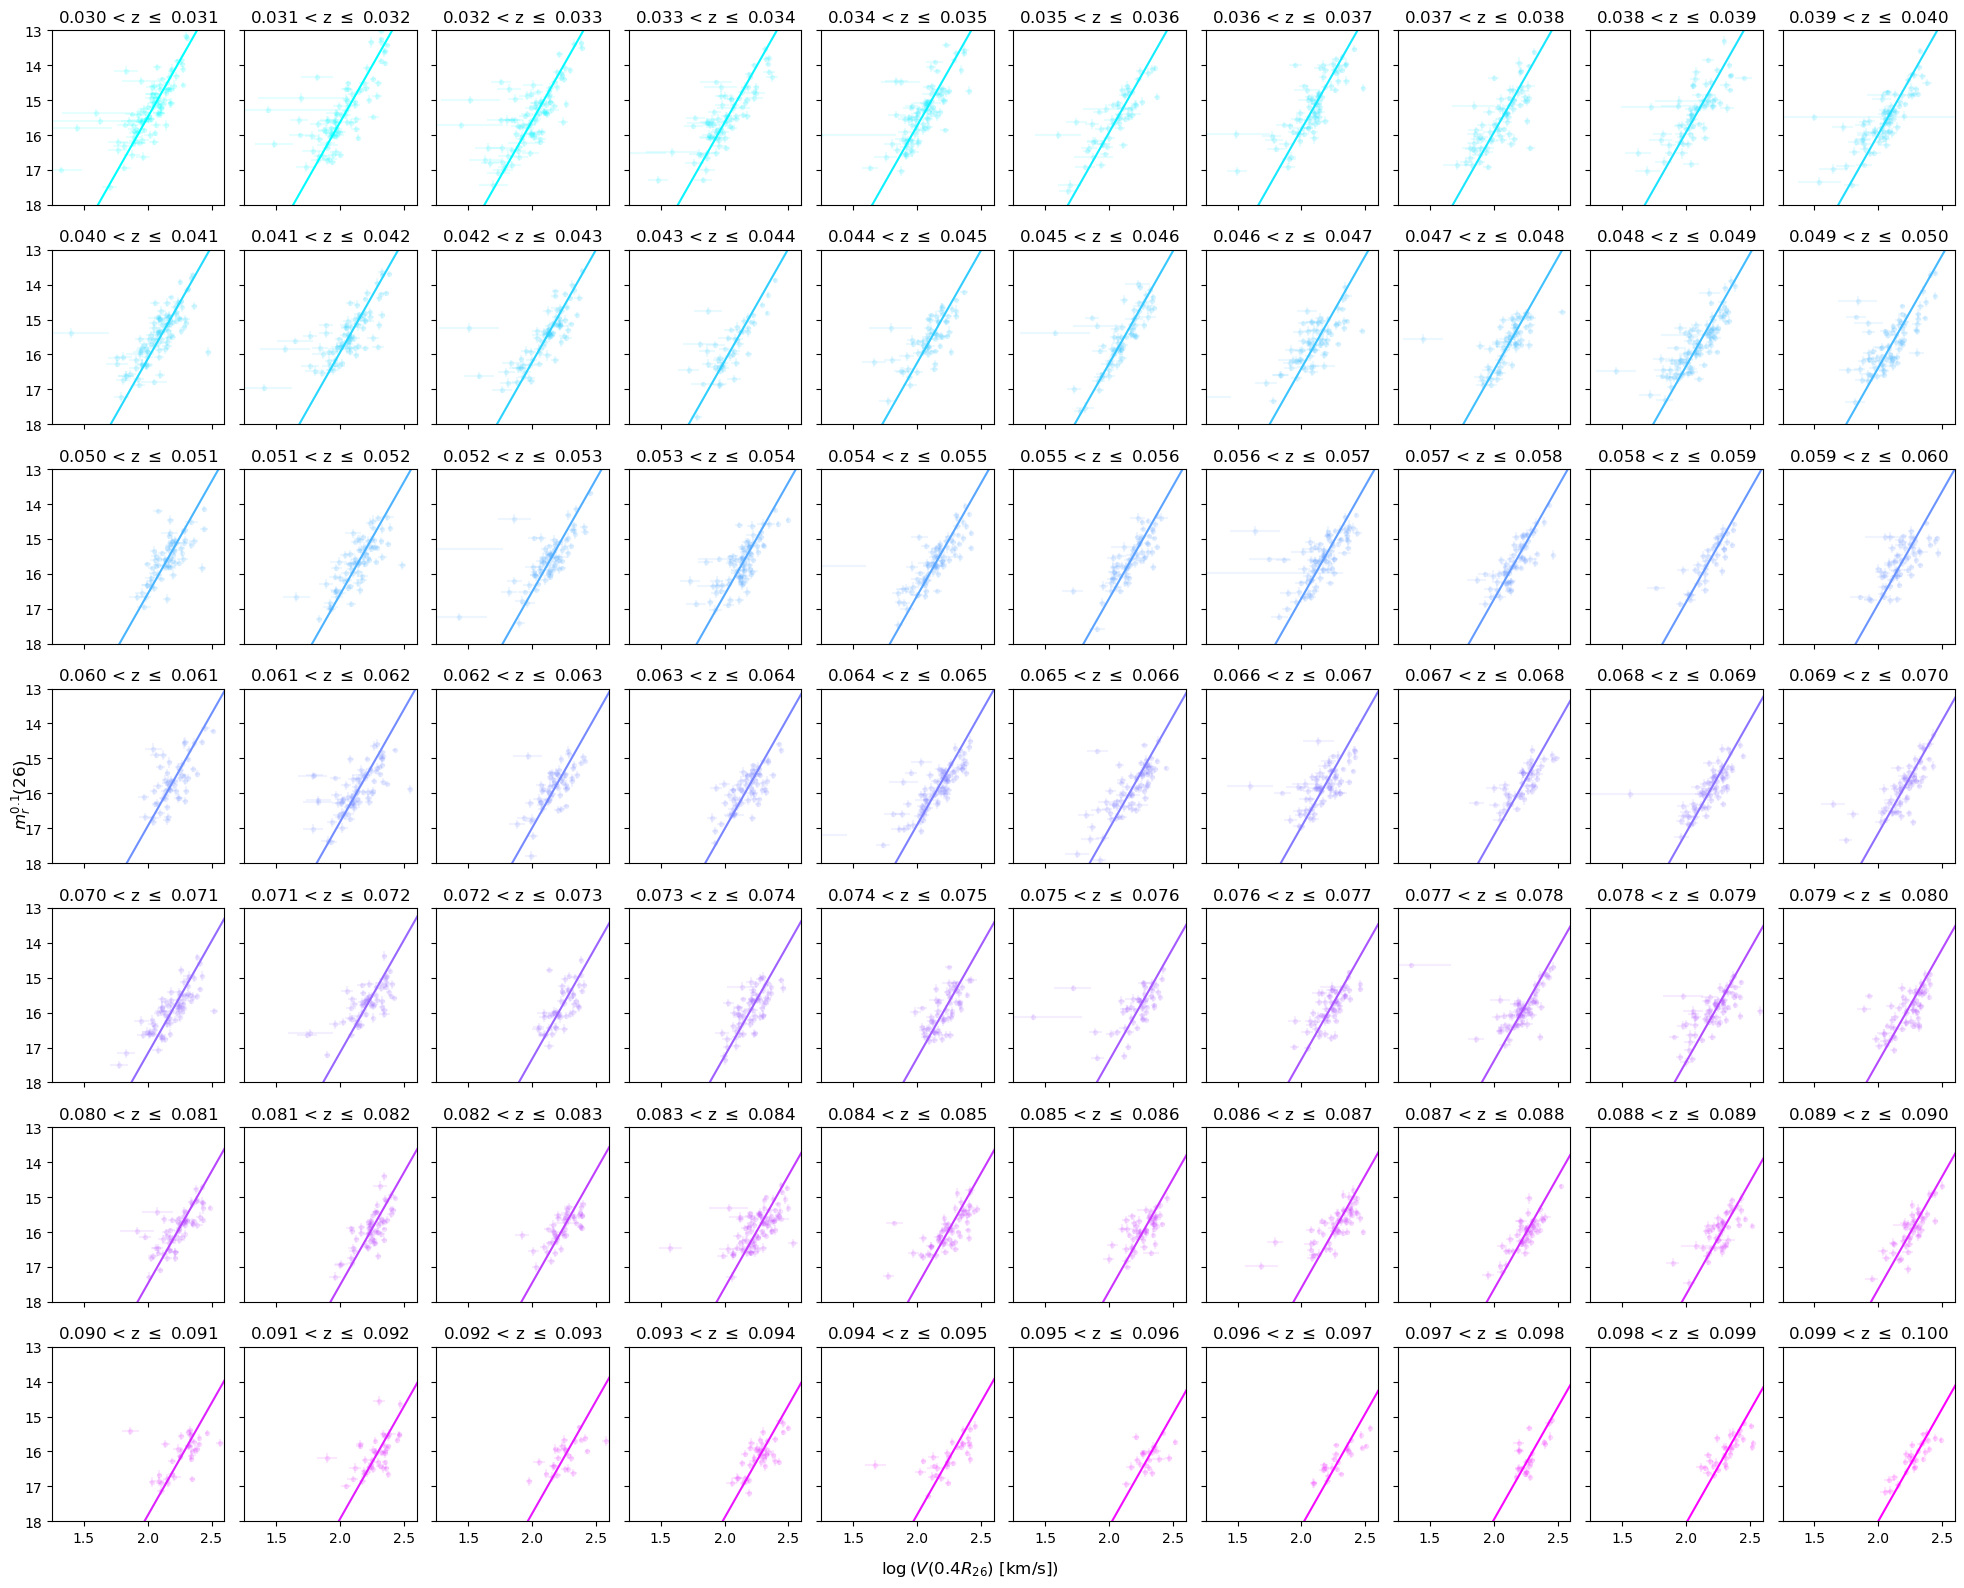

In [74]:
fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
# fig, axs = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10,8), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/10)
    col = i%10
    
    eb = axs[row,col].errorbar(logV[i+1] + logV0, mag[i+1], xerr=logV_err[i+1], yerr=mag_err[i+1], fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.25, 2.6], ylim=[18, 13], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')